In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


## 1. Read data

In [2]:
data = pd.read_csv('insurance.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [5]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# Convert categorical data to numerical data
label_encoder = LabelEncoder()

# Sex
label_encoder.fit(data["sex"])
data["sex"] = label_encoder.transform(data["sex"])

# Smoker
label_encoder.fit(data["smoker"])
data["smoker"] = label_encoder.transform(data["smoker"])

# Region
label_encoder.fit(data["region"])
data["region"] = label_encoder.transform(data["region"])


In [7]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


## 2. Data Analysis

<AxesSubplot:>

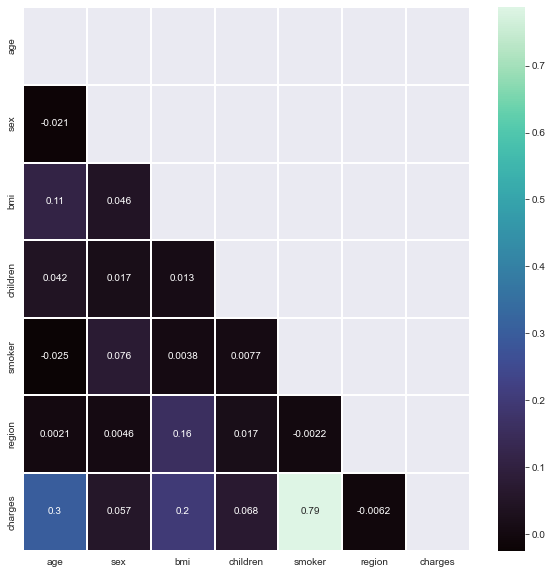

In [8]:
sns.set_style("darkgrid")

# Analyze Pearson correlation between the features
plt.figure(figsize=(10, 10))

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True

# Create colormap for better visualization
colormap = sns.color_palette("mako", as_cmap=True)

sns.heatmap(data.corr(), annot=True, mask=mask, cmap=colormap, linewidths=0.3)

We observe high correlation between smoking and charges.

<AxesSubplot:xlabel='charges', ylabel='Count'>

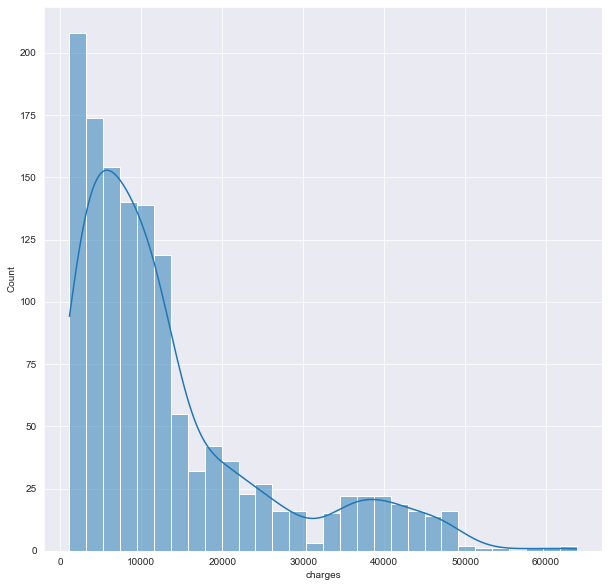

In [9]:
# See the distribution of charges
plt.figure(figsize=(10, 10))
sns.histplot(data["charges"], kde=True)


<AxesSubplot:xlabel='smoker', ylabel='charges'>

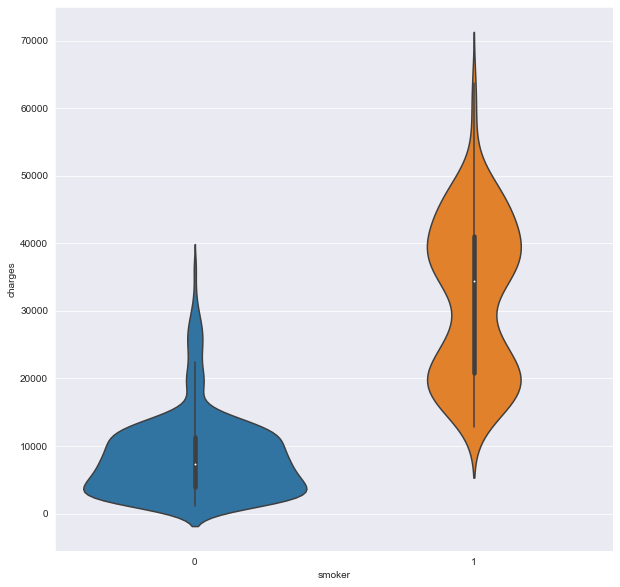

In [10]:
# Let's see if smoking has an effect on the insurance cost

plt.figure(figsize=(10, 10))
sns.violinplot(x='smoker', y='charges', data=data)

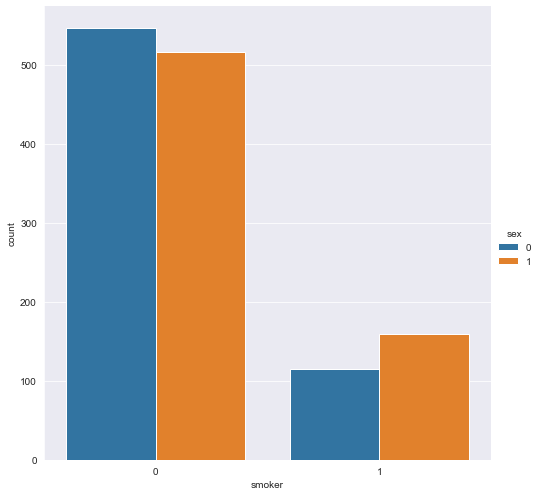

In [11]:
# Let's see the sex distribution of smokers and non-smokers
sns.catplot(x="smoker", hue="sex", kind="count", data=data, height=7, aspect=1)

<AxesSubplot:xlabel='age_group', ylabel='charges'>

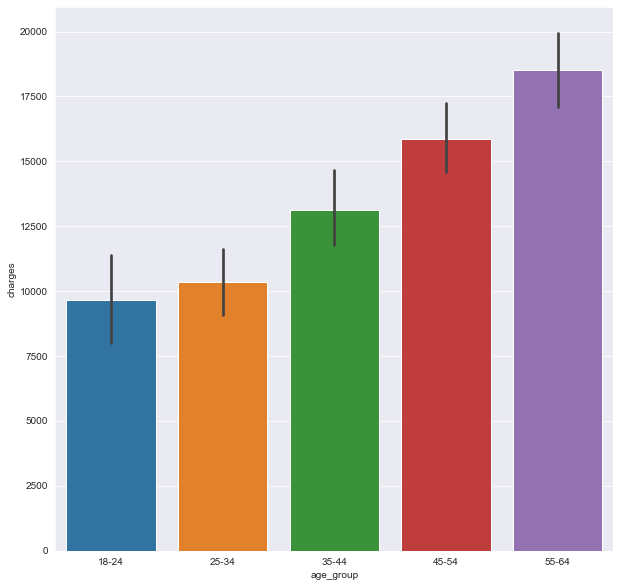

In [12]:
# Analyze different age groups
age_bins = [18, 24, 34, 44, 54, 64]
age_labels = ["18-24", "25-34", "35-44", "45-54", "55-64"]
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)

plt.figure(figsize=(10, 10))
sns.barplot(data=data, x = 'age_group', y = 'charges')

<AxesSubplot:xlabel='children', ylabel='charges'>

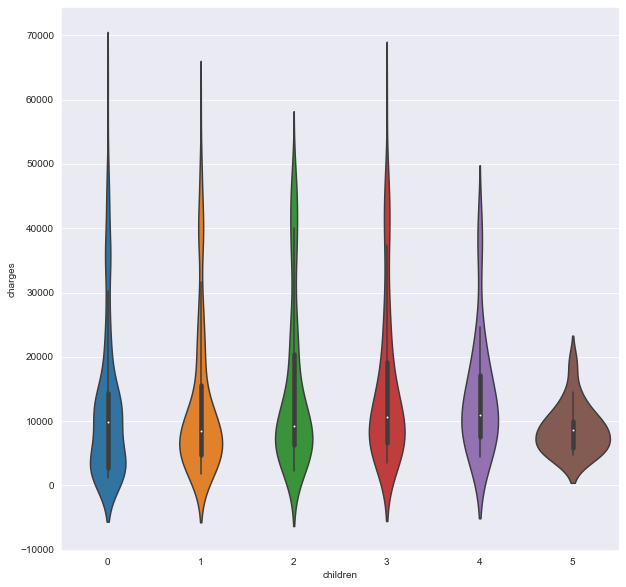

In [13]:
# Let's see if having children has an effect on the insurance cost
plt.figure(figsize=(10, 10))
sns.violinplot(x='children', y='charges', data=data)

<AxesSubplot:xlabel='bmi', ylabel='Count'>

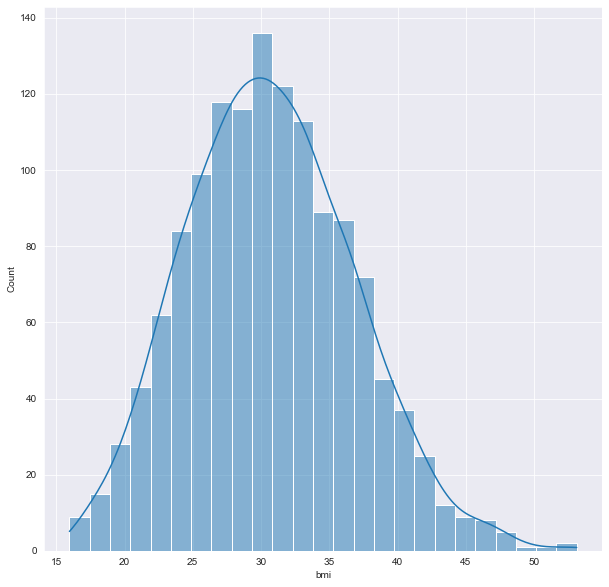

In [14]:
# BMI distribution
plt.figure(figsize=(10, 10))
sns.histplot(data["bmi"], kde=True)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

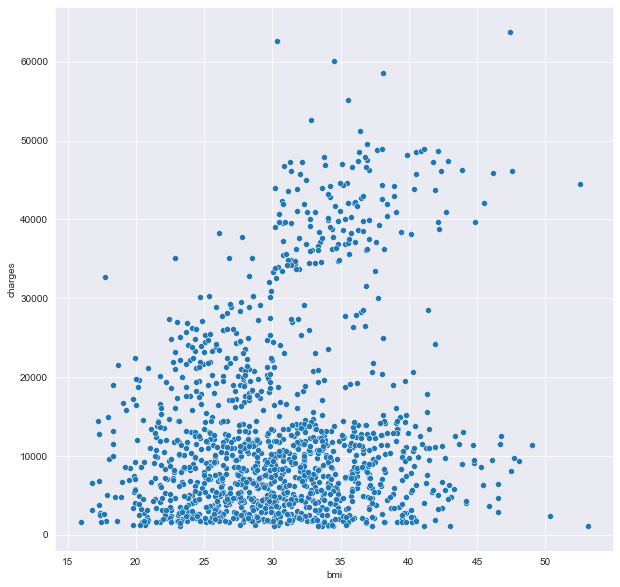

In [15]:
# Let's see if BMI has an effect on the insurance cost
plt.figure(figsize=(10, 10))
sns.scatterplot(x='bmi', y='charges', data=data)

<AxesSubplot:xlabel='bmi', ylabel='charges'>

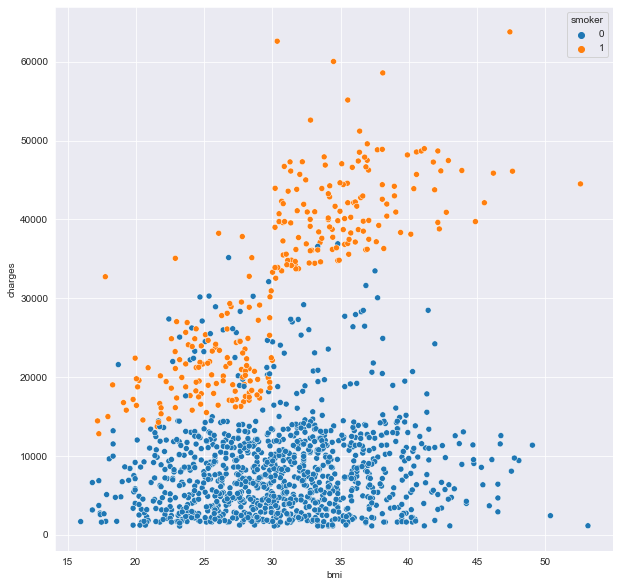

In [16]:
# BMI with smoking
plt.figure(figsize=(10, 10))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=data)

<AxesSubplot:xlabel='age_group', ylabel='bmi'>

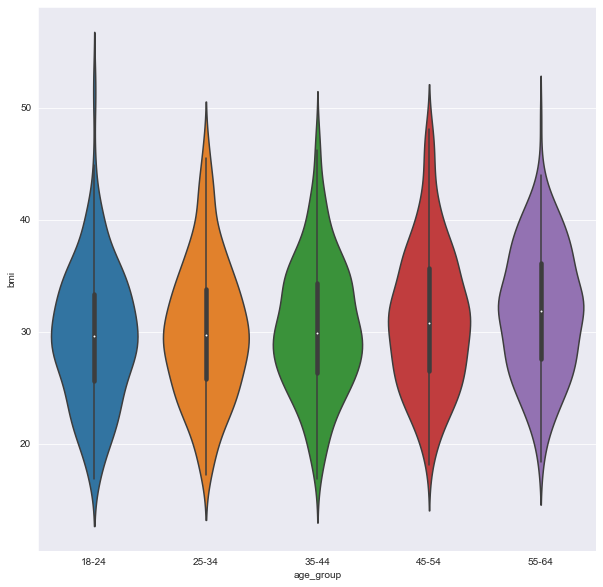

In [17]:
# BMI with age group
plt.figure(figsize=(10, 10))
sns.violinplot(x='age_group', y='bmi', data=data)

## Findings from Explaratory Data Analysis
- It is evident that smoking is strongly associated with higher insurance costs, as non-smokers pay an average of less than $1000, 
while smokers pay an average of around $3500.
- The distribution of insurance charges is skewed to the right, with most people paying around $1000.
- Women make up the majority of non-smokers, while men make up the majority of smokers. Consequently, men tend to pay more for insurance than women.
- Analysis of costs across different age groups reveals that individuals aged 55-64 pay the highest insurance costs, while those aged 18-24 pay the lowest. Insurance costs generally decrease as age decreases.
- Having children does not appear to have a significant effect on insurance costs. Interestingly, individuals with no children and those with three or four children pay the highest costs on average.
- Based on research, a healthy BMI falls within the range of 18.5 to 24.9, while an overweight BMI falls within 25.0 to 29.9, and an obese BMI is 30.0 or higher. [Source](https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%2018.5,falls%20within%20the%20obese%20range.)
- The distribution of BMI follows a normal pattern with an average of 30, a minimum of 15, and a maximum of 53. A scatter plot analysis of BMI and insurance costs shows that individuals with a BMI greater than 30 tend to have insurance costs above $3000, consistent with previous findings.
- When examining the scatter plot for BMI while filtering for smoking status, individuals who pay less than ~$1200 for insurance are always non-smokers, regardless of their BMI.
- Smokers with a BMI greater than 30 tend to have the highest insurance costs.
- Individuals aged 18-44 tend to have similar BMIs on average, while those aged 45-64 tend to have higher BMIs on average.

## 3. Models

In [18]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data.drop(['charges', 'age_group'], axis=1), data['charges'], test_size=0.2, random_state=42)

In [19]:
# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [20]:
# Define several regression models
scores = {}
models = [['Linear Regression', LinearRegression()], 
          ['Ridge Regression', Ridge()], 
          ['Lasso Regression', Lasso()], 
          ['Decision Tree Regression', DecisionTreeRegressor()], 
          ['Random Forest Regression', RandomForestRegressor()], 
          ['XGBoost Regression', XGBRegressor()],
          ['Support Vector Regression', SVR()]]


In [21]:
# Fit the models
for name, model in models:
    model.fit(x_train, y_train)
    scores[name] = r2_score(y_test, model.predict(x_test))
    print(name, 'R-squared score on test data:', scores[name], 'rmse:', np.sqrt(mean_squared_error(y_test, model.predict(x_test))))

Linear Regression R-squared score on test data: 0.7833463107364537 rmse: 5799.587091438359
Ridge Regression R-squared score on test data: 0.7833037457661383 rmse: 5800.156772780016
Lasso Regression R-squared score on test data: 0.7833293535279202 rmse: 5799.814050147892
Decision Tree Regression R-squared score on test data: 0.7381516260461526 rmse: 6375.862914109615
Random Forest Regression R-squared score on test data: 0.8684488116478437 rmse: 4519.198503928283
XGBoost Regression R-squared score on test data: 0.8546465198890332 rmse: 4750.36244987078
Support Vector Regression R-squared score on test data: -0.06821813183902203 rmse: 12877.868997800848


<AxesSubplot:>

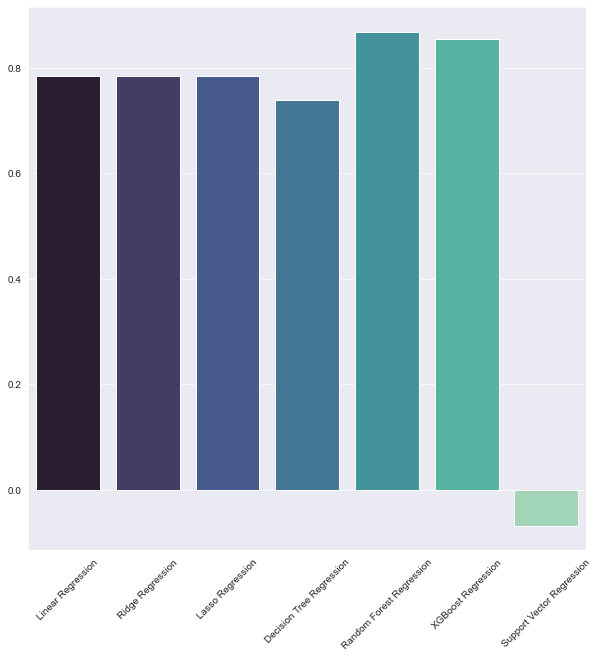

In [22]:
# Let's see the results
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="mako")

The RandomForestRegressor model has achieved the highest R-squared value of 0.86. To optimize its performance, we can perform a parameter search to fine-tune the model.

### Fine tune the Random Forest Regressor

In [23]:
# Define params for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [24]:
# Perform grid search
rf_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print(grid_search.best_params_)

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [49]:
# Let's see the results
rf_tuned = RandomForestRegressor(max_depth=5, max_features='auto', min_samples_leaf=2, min_samples_split=10, n_estimators=50)
rf_tuned.fit(x_train, y_train)
print(r2_score(y_test, rf_tuned.predict(x_test)))

0.878054953904991


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

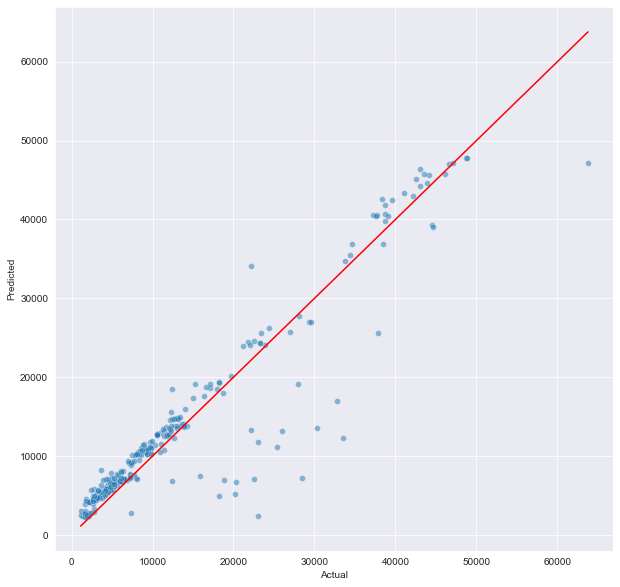

In [26]:
# Plot actual vs predicted values
y_test_pred = rf_tuned.predict(x_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

plt.figure(figsize=(10, 10))
sns.scatterplot(x='Actual', y='Predicted', data=results, alpha=0.5)
sns.lineplot(x=results['Actual'], y=results['Actual'], color='red')

<AxesSubplot:>

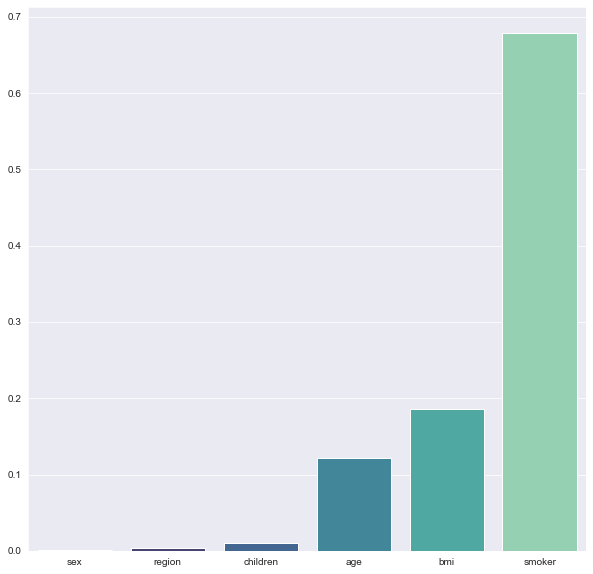

In [27]:
# Let's see the feature importances
sort_indices = np.argsort(rf_tuned.feature_importances_)

plt.figure(figsize=(10,10))
sns.barplot(x=data.drop('charges', axis=1).columns[sort_indices], y=rf_tuned.feature_importances_[sort_indices], palette="mako")

# 4. Conclusion
- Among the several regression models trained, the Random Forest Regressor showed the highest R-squared value of 0.86.
- The Random Forest Regressor was fine-tuned further and its R-squared value improved to 0.88.
- The most important features in the model were found to be "smoker", "bmi", and "age", which aligns with the data analysis we conducted.
- Features "sex", "region", and "children" had minimal impact on the predictions as their coefficients were very small.